In [1]:
from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
from pynq import allocate, Overlay

In [3]:
#canny_design = Overlay('/home/xilinx/design_1.bit')
canny_design = Overlay('/home/xilinx/pynq/overlays/canny2/design_1_wrapper.bit')
grayscale_accel = canny_design.grayscale_accel2_0
canny = canny_design.canny_accel_0
trace = canny_design.edgetracing_accel_0

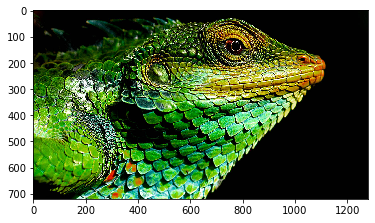

In [4]:
image_path = "/home/xilinx/jupyter_notebooks/pynq_composable/Small_Scaled_Forest_Lizard.jpg"
original_image = Image.open(image_path)

np_array = np.array(original_image)
width, height = original_image.size

#fake_video = np.zeros([120, width, height, 3], dtype=np.uint8)
#print(fake_video.shape)

plt.figure(1)
plt.imshow(np_array)


In [16]:
def load_and_downscale_video(video_path, num_frames=60, resolution="360p"):
    """
    Loads an MP4 video, extracts the first 'num_frames', downscales them to 'resolution',
    and returns a NumPy array of frames in uint8 format.

    Args:
        video_path (str): Path to the MP4 video file.
        num_frames (int, optional): Number of frames to extract. Defaults to 60.
        resolution (str, optional): Target resolution for downscaling. Defaults to "360p".

    Returns:
        np.ndarray: NumPy array of downscaled frames in uint8 format.
    """

    cap = cv2.VideoCapture(video_path)

    # Check if video opened successfully
    if not cap.isOpened():
        raise ValueError("Error opening video file:", video_path)

    # Get frame dimensions to calculate downscaling factors
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Handle invalid resolution input
    if resolution.lower() not in ["360p", "480p", "720p", "1080p"]:
        raise ValueError("Invalid resolution:", resolution)

    # Calculate downscaling factors based on resolution
    down_scale_factors = {
        "360p": (640 / frame_width, 360 / frame_height),
        "480p": (854 / frame_width, 480 / frame_height),
        "720p": (1280 / frame_width, 720 / frame_height),
        "1080p": (1920 / frame_width, 1080 / frame_height),
    }
    down_scale_factor = down_scale_factors[resolution.lower()]

    frames = []
    for i in range(num_frames):
        ret, frame = cap.read()

        # Check if frame reading was successful
        if not ret:
            break

        # Resize the frame (consider aspect ratio preservation if needed)
        frame = cv2.resize(frame, None, fx=down_scale_factor[0], fy=down_scale_factor[1],
                           interpolation=cv2.INTER_AREA)  # Use INTER_AREA for better downscaling
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        frames.append(frame.astype(np.uint8))

    cap.release()

    return np.array(frames)

# Example usage:
video_path = "../pynq_composable/mountains.mp4"
np_array = load_and_downscale_video(video_path)

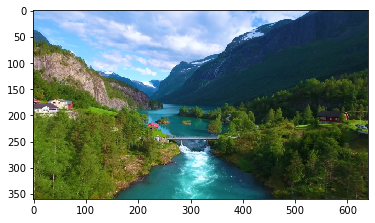

In [17]:
FRAMES = np_array.shape[0]
height, width = np_array.shape[1:3]
plt.figure(1)
plt.imshow(np_array[39])

In [13]:
pre_buffer = allocate(shape=(FRAMES, height, width, 3), dtype=np.uint8, cacheable=1)
gray_buffer0 = allocate(shape=(height, width), dtype=np.uint8, cacheable=1)
gray_buffer1 = allocate(shape=(height, width), dtype=np.uint8, cacheable=1)
out_buffer = allocate(shape=(FRAMES, height//2, width//2), dtype=np.uint8, cacheable=1)

gray_buf_list = [gray_buffer0.physical_address, gray_buffer1.physical_address]

grayscale_accel.register_map.rows = height
grayscale_accel.register_map.cols = width

canny.register_map.rows = height
canny.register_map.cols = width
canny.register_map.low_threshold = 100
canny.register_map.high_threshold = 200

In [14]:
#del pre_buffer
#del gray_buffer
#del out_buffer

In [19]:
import time
# write video to buffer
for i in range(FRAMES):
    pre_buffer[i][:] = np_array[i].copy()

In [20]:
gray_flag = 0
canny_flag = 0
gr_i = 1

pre_buf_addr = []
out_buf_addr = []
for i in range(FRAMES):
    pre_buf_addr.append(pre_buffer[i].physical_address)
    out_buf_addr.append(out_buffer[i].physical_address)

start_time = time.time()
for i in range(FRAMES + 1):
    gray_flag = 0
    canny_flag = 0
    
    if i < FRAMES:
        grayscale_accel.register_map.img_inp_1 = pre_buf_addr[i]
    if i == 0:
        grayscale_accel.register_map.img_out_1 = gray_buf_list[0]
        grayscale_accel.register_map.CTRL.AP_START=1
        while True:
            if grayscale_accel.register_map.CTRL.AP_DONE == 1:
                break
        #print("First frame")

    # i > 0
    elif i > 0 and i < FRAMES:
        # buffer alloc
        grayscale_accel.register_map.img_out_1 = gray_buf_list[gr_i]
        
        canny.register_map.img_inp_1 = gray_buf_list[not gr_i]
        canny.register_map.img_out_1 = out_buf_addr[i-1]
        
        # start accellerators
        grayscale_accel.register_map.CTRL.AP_START=1
        canny.register_map.CTRL.AP_START=1
        
        # wait for both to finish
        #print("waiting to finish")
        while True:
            if grayscale_accel.register_map.CTRL.AP_DONE == 1:
                gray_flag = 1
            if canny.register_map.CTRL.AP_DONE == 1:
                canny_flag = 1
            if gray_flag  == 1 and canny_flag == 1:
                break
        #print(f"Finished index {i}")
                
        # buffer index swap
        gr_i = not gr_i
        
    else:
        canny.register_map.img_inp_1 = gray_buf_list[not gr_i]
        canny.register_map.img_out_1 = out_buf_addr[i-1]
        canny.register_map.CTRL.AP_START=1
        while True:
            if canny.register_map.CTRL.AP_DONE == 1:
                break
        #print("Last frame")
                
end_time = time.time()

#out_array = np.zeros([30, height // 2, width // 2], dtype=np.uint8)

print("TIME: ", end_time - start_time)
print("AVG: ", (end_time - start_time) / FRAMES)

TIME:  0.688413143157959
AVG:  0.011473552385965983


In [24]:
print(type(out_buffer))
final_output = np.array(out_buffer.copy())
del pre_buffer
del gray_buffer0
del gray_buffer1
del out_buffer

<class 'pynq.buffer.PynqBuffer'>


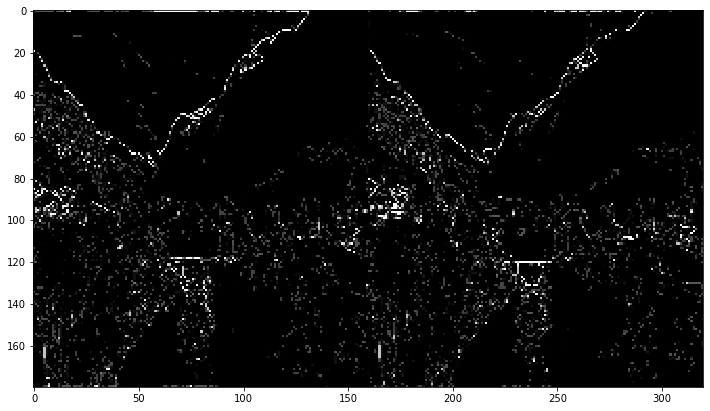

In [25]:
recieved = np.array(final_output[5])
plt.figure(figsize=(12, 10));
_ = plt.imshow(recieved, cmap = 'gray')


In [ ]:
def pixel_unpack2(packed)
    packed_shape = packed.shape
    unpacked_shape = [packed_shape[0] * 2, packed_shape[1] * 2]

    packed_flat = packed.flatten()
    unpacked_flat = np.zeros([unpacked_shape[0] * unpacked_shape[1]], dtype=np.uint8)
    
    unpacked_index = 0
    for i, pixel_quad in enumerate(packed_flat):
        
        unpacked_flat[0] = (pixel_quad & 0b00000011)
        unpacked_flat[1] = (pixel_quad & 0b00001100) >> 2
        unpacked_flat[2] = (pixel_quad & 0b00110000) >> 4
        unpacked_flat[3] = (pixel_quad & 0b11000000) >> 6
        
        unpacked_flat[unpacked_index] = two_bits
        unpacked_flat[unpacked_index] = two_bits
        unpacked_flat[unpacked_index] = two_bits
        unpacked_flat[unpacked_index] = two_bits
        for j in range(4):
            # Extract 2 bits for each pixel using bitwise AND and right shift
            two_bits = (pixel_quad >> (j * 2)) & 0b11
            # Convert 2 bits to an unsigned byte (0-3)
            unpacked_flat[unpacked_index] = two_bits
            unpacked_index += 1
    return unpacked_flat.reshape(unpacked_shape)

In [26]:
def pixel_unpack(packed):
    packed_shape = packed.shape
    unpacked_shape = [packed_shape[0] * 2, packed_shape[1] * 2]

    packed_flat = packed.flatten()
    unpacked_flat = np.zeros([unpacked_shape[0] * unpacked_shape[1]], dtype=np.uint8)
    
    unpacked_index = 0
    for i, pixel_quad in enumerate(packed_flat):
        for j in range(4):
            # Extract 2 bits for each pixel using bitwise AND and right shift
            two_bits = (pixel_quad >> (j * 2)) & 0b11
            # Convert 2 bits to an unsigned byte (0-3)
            unpacked_flat[unpacked_index] = two_bits
            unpacked_index += 1
    return unpacked_flat.reshape(unpacked_shape)

In [27]:
final_output_unpacked = []
for i, frame in enumerate(final_output):
    frame_unpacked = pixel_unpack(frame)
    final_output_unpacked.append(frame_unpacked.copy())
    print(f"Unpacked {i} frames")


Unpacked 0 frames
Unpacked 1 frames
Unpacked 2 frames
Unpacked 3 frames
Unpacked 4 frames
Unpacked 5 frames
Unpacked 6 frames
Unpacked 7 frames
Unpacked 8 frames
Unpacked 9 frames
Unpacked 10 frames
Unpacked 11 frames
Unpacked 12 frames
Unpacked 13 frames
Unpacked 14 frames
Unpacked 15 frames
Unpacked 16 frames
Unpacked 17 frames
Unpacked 18 frames
Unpacked 19 frames
Unpacked 20 frames
Unpacked 21 frames
Unpacked 22 frames
Unpacked 23 frames
Unpacked 24 frames
Unpacked 25 frames
Unpacked 26 frames
Unpacked 27 frames
Unpacked 28 frames
Unpacked 29 frames
Unpacked 30 frames
Unpacked 31 frames
Unpacked 32 frames
Unpacked 33 frames
Unpacked 34 frames
Unpacked 35 frames
Unpacked 36 frames
Unpacked 37 frames
Unpacked 38 frames
Unpacked 39 frames
Unpacked 40 frames
Unpacked 41 frames
Unpacked 42 frames
Unpacked 43 frames
Unpacked 44 frames
Unpacked 45 frames
Unpacked 46 frames
Unpacked 47 frames
Unpacked 48 frames
Unpacked 49 frames
Unpacked 50 frames
Unpacked 51 frames
Unpacked 52 frames
Unp

In [29]:
final_output_unpacked_np = np.array(final_output_unpacked)
print(final_output_unpacked_np.shape)
print(final_output_unpacked_np.dtype)

(60, 360, 640)
uint8


In [37]:
# Save video
video_array = final_output_unpacked_np * 85

size = 360, 640

duration = 2
fps = 25
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]), False)
for i in range(60):
    data = video_array[i]
    out.write(data)
out.release()

In [45]:
all_edges = []
start_time = time.time()

for i, frame in enumerate(np_array):
    edge = cv2.Canny(frame,100,200)
    all_edges.append(edge)
end_time = time.time()
print("TIME: ", end_time - start_time)
print("AVG: ", (end_time - start_time) / FRAMES)

TIME:  3.2114453315734863
AVG:  0.0535240888595581
